In [1]:
import cv2
import numpy as np

## Setting up camera

In [2]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [3]:
def try_camera(func):
    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [8]:
# ! {"pip install matplotlib"}

In [9]:
frame = np.load('open_palm.npy')

In [10]:
import matplotlib.pyplot as plt

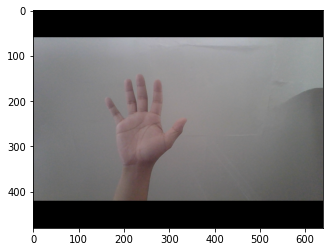

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [12]:
frame.shape

(480, 640, 3)

In [13]:
def get_skinmask(frame):
    lower_HSV = np.array([0, 40, 0], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


    lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
    return skinMask

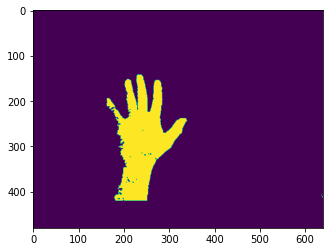

In [14]:
plt.imshow(get_skinmask(frame))

Testing Code

In [15]:
try_camera(get_skinmask)

In [16]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask) 
    return skin

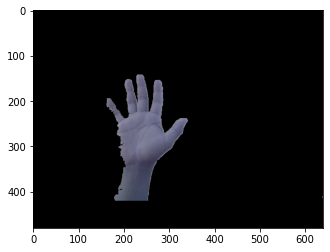

In [17]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [18]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
try_camera(isolate)

## Part 2: Connected Components for Gesture Recognition

In [19]:
ok_hand = np.load('ok.npy')

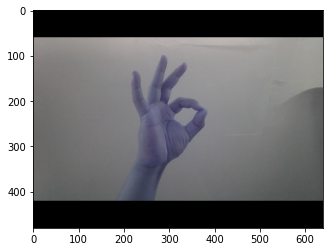

In [20]:
plt.imshow(ok_hand)

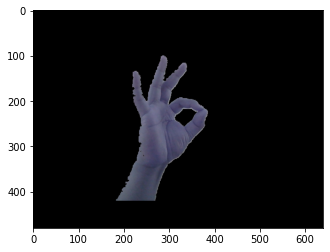

In [21]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [22]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

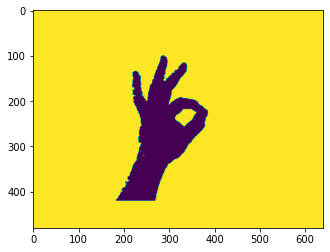

In [23]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [24]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [25]:
try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [26]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [27]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

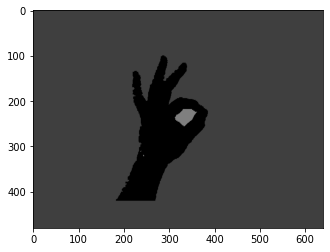

In [28]:
plt.imshow(marks)

Test out code so far...

In [29]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
try_camera(render_comps)

In [30]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [31]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

(x=5.813216209411621, y=3.5381453037261963), (MA=7.042591094970703, ma=13.125836372375488), Angle=101.30936431884766
(x=6.112511157989502, y=4.487914085388184), (MA=7.417097091674805, ma=13.917428970336914), Angle=103.5970687866211
(x=5.404443740844727, y=4.010930061340332), (MA=7.655084133148193, ma=11.362823486328125), Angle=114.68160247802734
(x=5.364366054534912, y=3.3620660305023193), (MA=7.31444787979126, ma=10.898948669433594), Angle=101.48367309570312
(x=6.33821964263916, y=3.0989224910736084), (MA=6.79210090637207, ma=12.341073989868164), Angle=97.59872436523438
(x=5.522599697113037, y=4.105334281921387), (MA=8.043655395507812, ma=10.193704605102539), Angle=99.95255279541016
(x=5.945882797241211, y=6.867010593414307), (MA=12.481569290161133, ma=12.847490310668945), Angle=138.46986389160156
(x=5.337625503540039, y=3.8298227787017822), (MA=7.244232654571533, ma=10.685290336608887), Angle=92.07424926757812
(x=5.286043167114258, y=3.7296881675720215), (MA=7.746373653411865, ma=10.

## Part 3: Tracking 2D Finger Positions

In [32]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

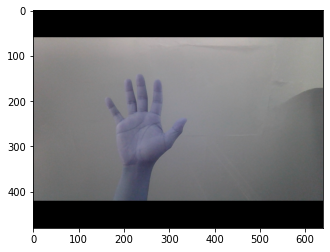

In [33]:
plt.imshow(np.load('open_palm.npy'))

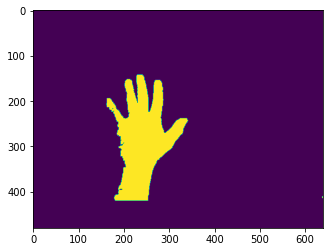

In [34]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [35]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [36]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

3


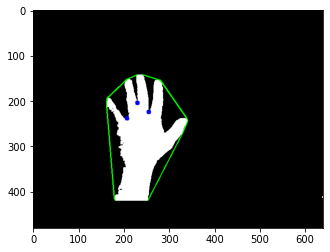

In [37]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [38]:
try_camera(get_conv_img)

1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
2
2
2
1
1
1
1
2
2
2
1
2
2
1
2
2
1
0
1
0
0
1
0
1
1
1
0
1
1
1
1
0
1
1
0
2
3
1
2
2
3
2
3
3
4
4
3
3
4
4
3
4
4
4
4
4
1
0
1
1
1
0
1
0
0
1
2
1
0
0
1
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0


c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0
0
0
0
0
3
4
6
4
7
7
4
4
2
4
3
3
2
3
3
4
3
3
3
4
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
4
3
3
3
4
3
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
3
3
3
4
3
3
4
4
3
3
4
3
3
3
5
3
3
3
3
3
3
3
3
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
3
3
3
3
5
5
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
3
3
3
3
3
3
3
3
3
4
3
3
3
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
4
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


## Part 4: Control Mouse and Keyboard

In [184]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,30)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    # cv2.circle(thresholdedHandImage,start,5,[i * 20,0,255],-1)
                    # cv2.circle(thresholdedHandImage,end,5,[i * 20 + 100,0,255],-1)
                    startEndPts.append([start[i] for i in range(len(start))])
                    # startEndPts.append([end[i] for i in range(len(end))])
                    
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)

            # print(tuple(np.ceil(mean_pts).astype(int).tolist()))
            open_closes.append(1)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        cv2.putText(thresholdedHandImage, "Closed", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            
    return thresholdedHandImage, centers, open_closes

In [186]:
cap = cv2.VideoCapture(0)
centers_arr = []
open_closes_arr = [-1]
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr)
    
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    # except:
    #     print("Nothing found...")
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in int_scalars
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
